# PLOT cellphoneDB selected interactions - GRANULOSA-GERM cells

In [1]:
library(dplyr)
library(RColorBrewer)
library(ggplot2)
library(pheatmap)
library(cowplot)
library(reshape2)
library(plyr)

format_expression_values = function(celltypes){
    # subset matrixes with celltypes
    cells = intersect(celltypes, colnames(percent))
    c_percent = as.matrix(percent[, cells])
    c_avgLog2 = avgLog2[, cells]
    # scale avgLog2
    rn = colnames(c_avgLog2)
    avgLog2_scaled = apply(t(c_avgLog2), 2, scale) 
    avgLog2_scaled = t(avgLog2_scaled)
    colnames(avgLog2_scaled) = rn
    
    # format as dataframe for ggplot2
    m_avgLog2 = melt(avgLog2_scaled)
    m_avgLog2$zscore_expression = m_avgLog2$value
    m_percent = melt(c_percent)
    m_percent$percent = m_percent$value * 100
    m_percent$gene = m_percent$Var1
    m_percent$celltype = m_percent$Var2
    m_avgLog2$id = paste(m_avgLog2$Var1, m_avgLog2$Var2)
    m_percent$id = paste(m_percent$Var1, m_percent$Var2)
    mdf = merge(m_avgLog2, m_percent, by = 'id')
    mdf = mdf[ , c('celltype', 'gene', 'percent', 'zscore_expression', 'id') ]
    
    return(mdf)
}

dotplot_genes2lineageV2 = function(celltypes, genes2plot, mdf, percent_thr = NULL, legend_loc = 'bottom'){
    celltypes = unique(celltypes)
    genes2plot = unique(genes2plot)
    # order partners as in previous plot
    mdf = subset(mdf, gene %in% genes2plot)
    mdf = subset(mdf, celltype %in% celltypes)
    # order as in target genes
    plot_df = do.call(rbind, lapply(genes2plot, function(i) subset(mdf, gene == i)  ))                                    
    plot_df$gene = factor(plot_df$gene, levels = genes2plot)                                 
    plot_df$celltype = factor(plot_df$celltype, levels = celltypes)
    plot_df = unique(plot_df)
    if( ! is.null(percent_thr) ){
        plot_df$percent = round(plot_df$percent, digits = 0)
        plot_df = subset(plot_df, percent >= percent_thr)
    }
    percent_breaks = round_any(seq(0, 80, length.out = 5), accuracy = 10)                                
    P = ggplot(plot_df,  aes(x = gene,
                         y = celltype,
                         color = zscore_expression,
                         size = percent)) +  
                                      geom_point() + 
                                      scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                                                            high = brewer.pal(n = 5, name = 'Reds')[4], 
                                                            mid = 'grey90', name="Mean expression (zscore)" )+
                                      labs(size="Fraction of cells",col="Mean expression (zscore)") +
                                     scale_size_continuous(breaks = percent_breaks)+
                                      theme_bw() + 
                                      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
                                           axis.title=element_blank(),
                                           legend.position = legend_loc, legend.box="vertical", legend.margin=margin(),legend.direction = "horizontal",
                                           legend.text = element_text(size=5), legend.title = element_text(size=5),
#                                            legend.box.margin=margin(10,-10,10,-10)
                                           )
                                    
    return(P)
}
                                    
                                    
dotplot_genes2lineageV1 = function(celltypes, genes2plot, mdf, percent_thr = NULL, legend_loc = 'left'){
    celltypes = unique(celltypes)
    genes2plot = unique(genes2plot)
    # order partners as in previous plot
    mdf = subset(mdf, gene %in% genes2plot)
    mdf = subset(mdf, celltype %in% celltypes)
    # order as in target genes
    plot_df = do.call(rbind, lapply(genes2plot, function(i) subset(mdf, gene == i)  ))                                    
    plot_df$gene = factor(plot_df$gene, levels = genes2plot)                                 
    plot_df$celltype = factor(plot_df$celltype, levels = celltypes)
    plot_df = unique(plot_df)
    if( ! is.null(percent_thr) ){
        plot_df$percent = round(plot_df$percent, digits = 0)
        plot_df = subset(plot_df, percent >= percent_thr)
    }
    percent_breaks = round_any(seq(0, 80, length.out = 5), accuracy = 10)                                
    P = ggplot(plot_df,  aes(x = celltype,
                         y = gene,
                         color = zscore_expression,
                         size = percent)) +  
                                      geom_point() + 
                                      scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                                                            high = brewer.pal(n = 5, name = 'Reds')[4], 
                                                            mid = 'grey90', name="Mean expression (zscore)" )+
                                      labs(size="Fraction of cells",col="Mean expression (zscore)") +
                                     scale_size_continuous(breaks = percent_breaks)+
                                      theme_bw() + 
                                      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
                                           axis.title=element_blank(),
                                           legend.position = legend_loc, legend.margin=margin(),
                                            #legend.direction = "horizontal", legend.box="vertical", 
                                            legend.key.height= unit(0.4, 'cm'),
                                            legend.key.width= unit(0.25, 'cm'),
                                           legend.text = element_text(size=5), legend.title = element_text(size=5)
#                                            legend.box.margin=margin(10,-10,10,-10)
                                           )
    if (legend_loc == 'left')
        P = P + scale_y_discrete(position = "right")
                                    
    return(P)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize




## Load expression values for plotting

In [2]:
avgLog2 = read.csv('cellphoneDB/in_granulosa/ovarian_average_log.csv', stringsAsFactors = F, row.names=1)
colnames(avgLog2) = gsub('Germ.', '', colnames(avgLog2))
colnames(avgLog2) = gsub('Somatic.', '', colnames(avgLog2))
colnames(avgLog2) = gsub('Epi', '', colnames(avgLog2))

percent = read.csv('cellphoneDB/in_granulosa/ovarian_percent.csv', stringsAsFactors = F, row.names=1)
colnames(percent) = gsub('Germ.', '', colnames(percent))
colnames(percent) = gsub('Somatic.', '', colnames(percent))
colnames(percent) = gsub('Epi', '', colnames(avgLog2))

In [19]:
head(percent)

,GC,PGC,oocyte,oogonia_STRA8,oogonia_meiotic,pre_oocyte,Coel_LHX9,OSE,early_supporting,granulosa,preGC_I,preGC_IIa,preGC_IIb
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,0.39,0.32,0.16,0.45,0.07,0.21,0.19,0.22,0.13,0.20,0.11,0.26,0.24
A1BG-AS1,0.02,0.03,0.07,0.03,0.01,0.04,0.01,0.03,0.02,0.02,0.01,0.02,0.03
A1CF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A2M,0.28,0.22,0.01,0.05,0.02,0.03,0.03,0.03,0.01,0.05,0.01,0.02,0.01
A2M-AS1,0.03,0.01,0.00,0.04,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
A2ML1,0.02,0.04,0.32,0.00,0.01,0.08,0.03,0.07,0.13,0.15,0.11,0.24,0.21


## Prepare expression data for plotting

In [20]:
somatic = c('Coel_LHX9', 'early_supporting', 'OSE', 'preGC_IIa', 'preGC_IIb','granulosa', 'preGC_I') %>% rev(.)
germ = c('PGC', 'GC', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_oocyte', 'oocyte') 


In [21]:
mdf_somatic = format_expression_values(somatic)
mdf_germ = format_expression_values(germ)

## PLOTS

In [22]:
outdir = 'cellphoneDB/plots/'

## Define genes to plot per microenviroment and lineage

In [23]:
cortex_somatic = c('BMP4','IGF1','PTGER3',  'PDGFRA','ADRA2A','ADRB3','EPHA4','EFNB2','EFNB3', 'CXCR4', 'KITLG', 'NRG1', 'NOTCH2')
cortex_germ = c( 'ACVR2B', 'BMPR1A', 'IGF1R', 'PTGES2', 'PTGES3',  'PDGFB', 'PNMT',
                  'EFNA4','EPHB4','CXCL12','CXCL14','KIT','ERBB3', 'DLL3')

medulla_somatic = c('NOTCH2', 'ESR1', 'CYP19A1', 'HSD17B1', 'AR','ACVR2B', 'BMPR1B','BMP2' ,
                     'STRA6', 'PTHLH' , 'ALDH1A1', 'EFNB1', 'NR1H4')
medulla_germ  = c( 'DLK1', 'ESR1', 'HSD17B12',  'BMP4',  'ACVR2B', 'BMPR1A',
                  'RBP4','PTH1R', 'RARA', 'CRABP2', 'EPHB6', 'CYP11A1', 'CYP19A1')

follicle_somatic = c('BMPR1B', 'BMPR2',  'TGFBR1', 'NOTCH2', 'NOTCH3', 'CD46', 'HRH1', 'ERBB4', 'RARRES2', 'EGFR', 'NTN1')
follicle_germ = c('ESR2',  'BMP6', 'GDF9', 'JAG1', 'HDC', 'NRG4', 'ALDH1A', 'CMKLR1','TGFA', 'DCC' ) 

## Ligand - receptors

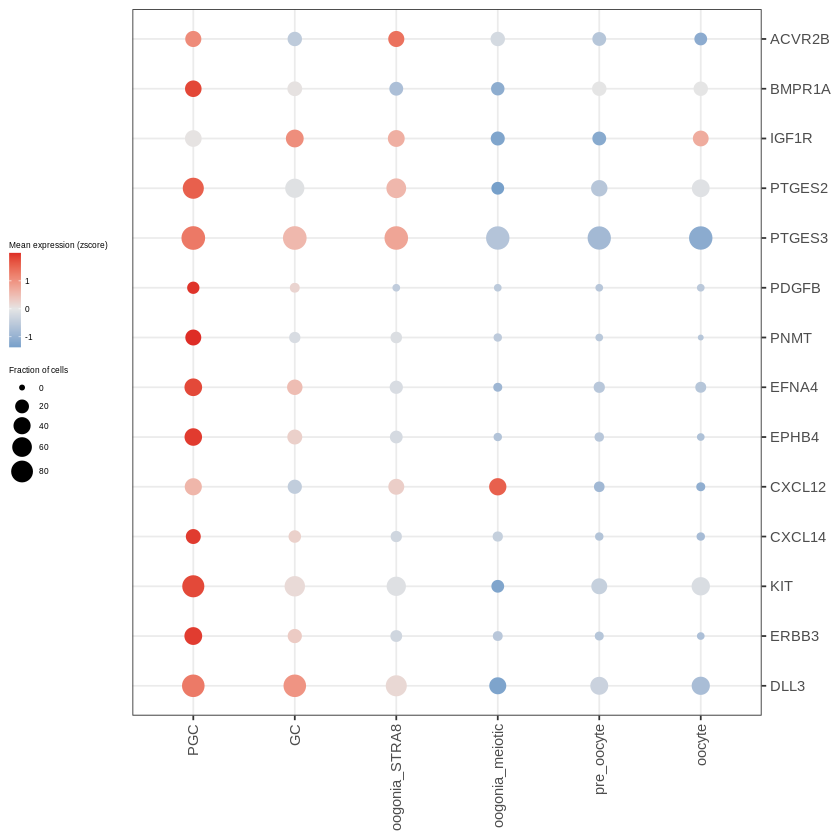

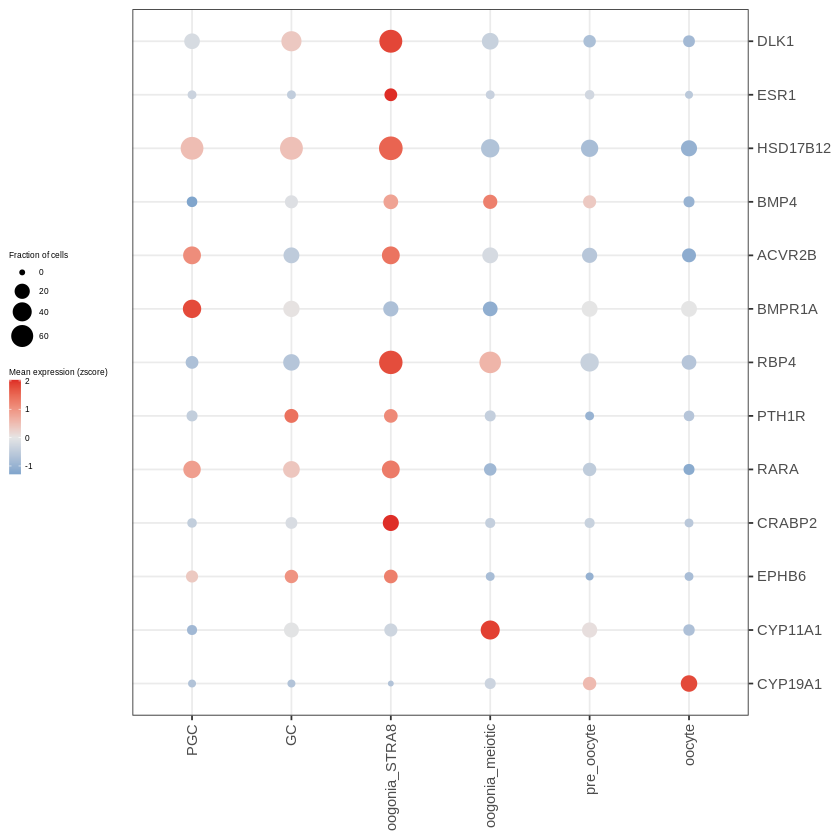

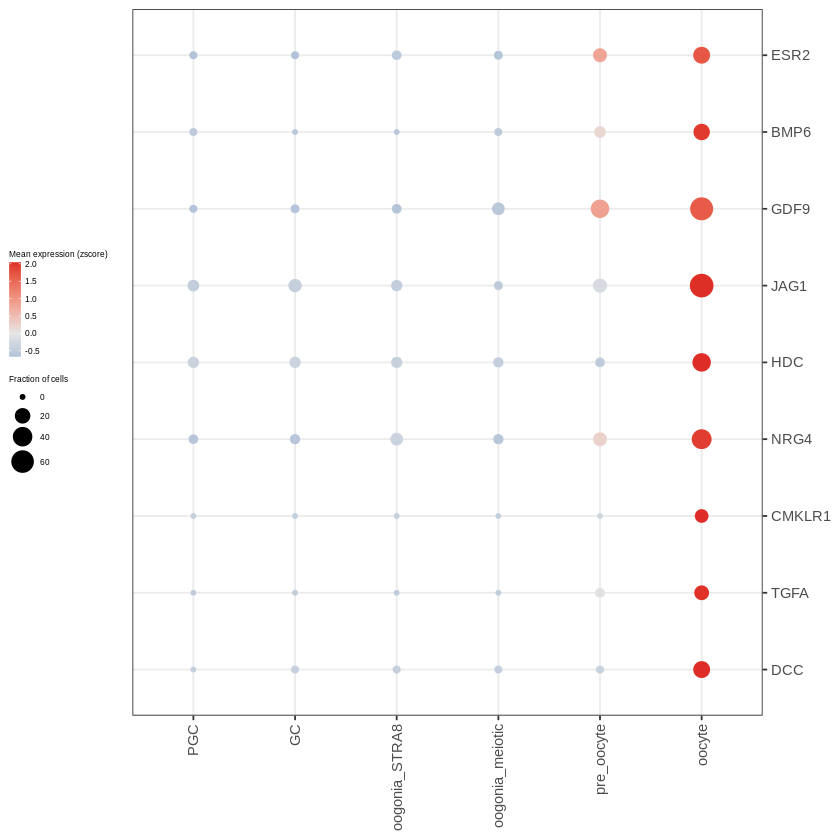

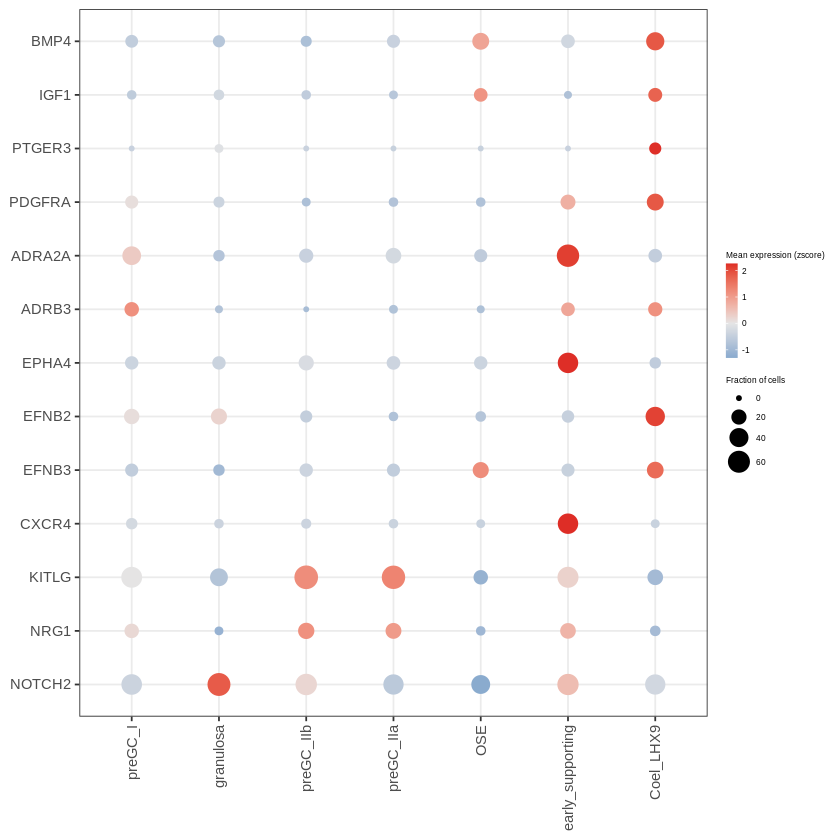

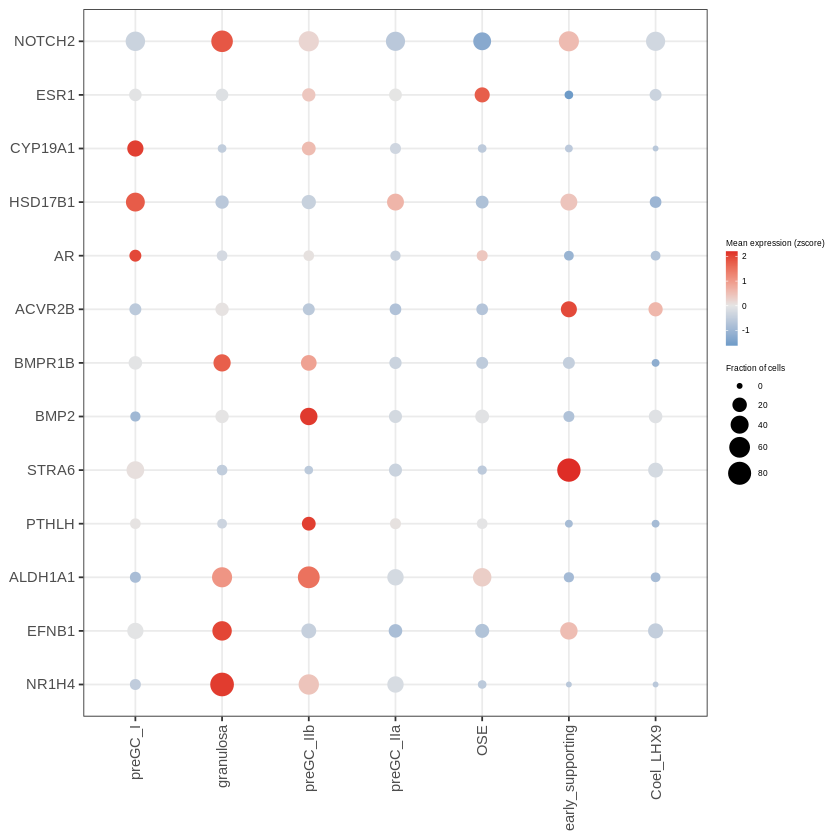

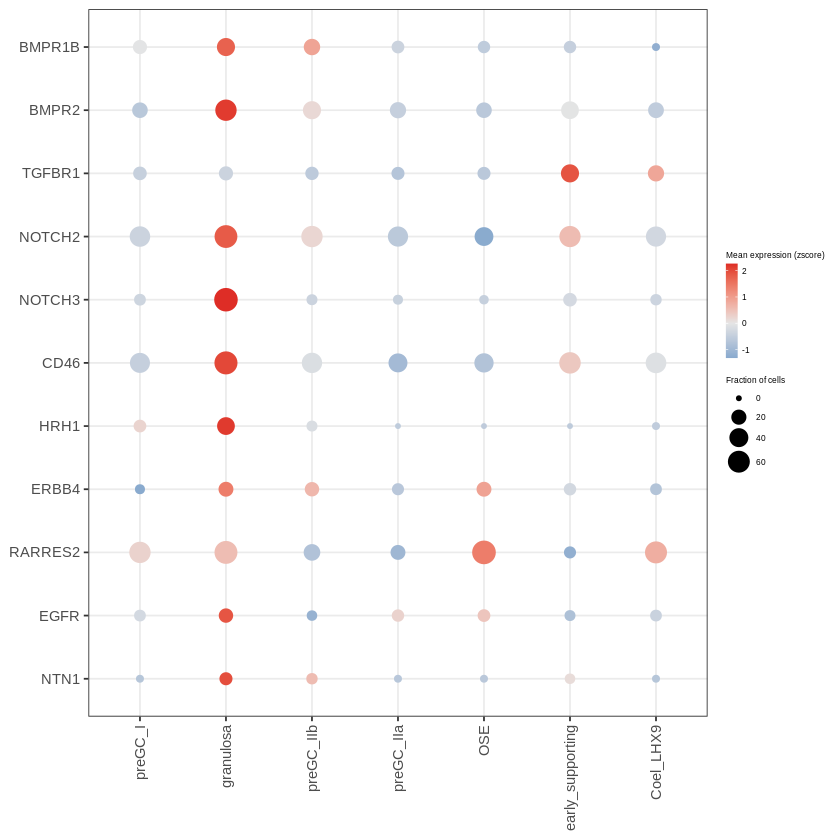

In [24]:
dotplot_genes2lineageV1(germ, rev(cortex_germ), mdf_germ, legend_loc='left')
ggsave(filename = paste0(outdir,'cortex_germ.pdf'), dpi = 300, width = 3.6, height = 3.25)
dotplot_genes2lineageV1(germ, rev(medulla_germ), mdf_germ, legend_loc='left')
ggsave(filename = paste0(outdir,'medulla_germ.pdf'), dpi = 300, width = 3.6, height = 3.25)
dotplot_genes2lineageV1(germ, rev(follicle_germ), mdf_germ, legend_loc='left')
ggsave(filename = paste0(outdir,'follicle_germ.pdf'), dpi = 300, width = 3.6, height = 3.25)


dotplot_genes2lineageV1(somatic, rev(cortex_somatic), mdf_somatic, legend_loc='right')
ggsave(filename = paste0(outdir,'cortex_somatic.pdf'), dpi = 300, width = 3.6, height = 3.25)
dotplot_genes2lineageV1(somatic, rev(medulla_somatic), mdf_somatic, legend_loc='right')
ggsave(filename = paste0(outdir,'medulla_somatic.pdf'), dpi = 300, width = 3.6, height = 3.25)
dotplot_genes2lineageV1(somatic, rev(follicle_somatic), mdf_somatic, legend_loc='right')
ggsave(filename = paste0(outdir,'follicle_somatic.pdf'), dpi = 300, width = 3.6, height = 3.25)

## ECM

In [17]:
EMC_germ = c('ITGA6', 'ITGB1', "NECTIN2", 'PTPRS',
             'CADM3',  'LAMC1',
               'JAM2', 'CD47','CADM1',
              'COL4A1', 'COL4A2',  'COL9A3',
             'COL6A3','COL6A1','COL6A2',  'COL14A1', 'KLRG1',
             "NECTIN3", 'COL1A1', 'COL1A2', 'COL3A1', 
             'ITGA4', "ITGAV",  'FN1',  'CDH1', "ITGA11") 

EMC_soma = c('ITGB4', 'COL5A2', 'COL8A1', 'AGRN',
            'COL9A3',   'COL16A1', 'COL27A1', 
             "NECTIN3",
            'ITGA5', 'JAM2',   'SIRPA', 
            'COL11A1', 'CADM1', 'CDH1','JAM3',
             'COL3A1', 'COL4A1', 'COL4A2',"COL4A3", "COL4A4",  'COL6A1', 'COL6A2', 'COL6A3',  'COL14A1',  'COL21A1', 
            'LAMC1',   'ITGA2', "ITGAV", 'ITGA6', 'ITGB1'
#             'ITGA8'
           )

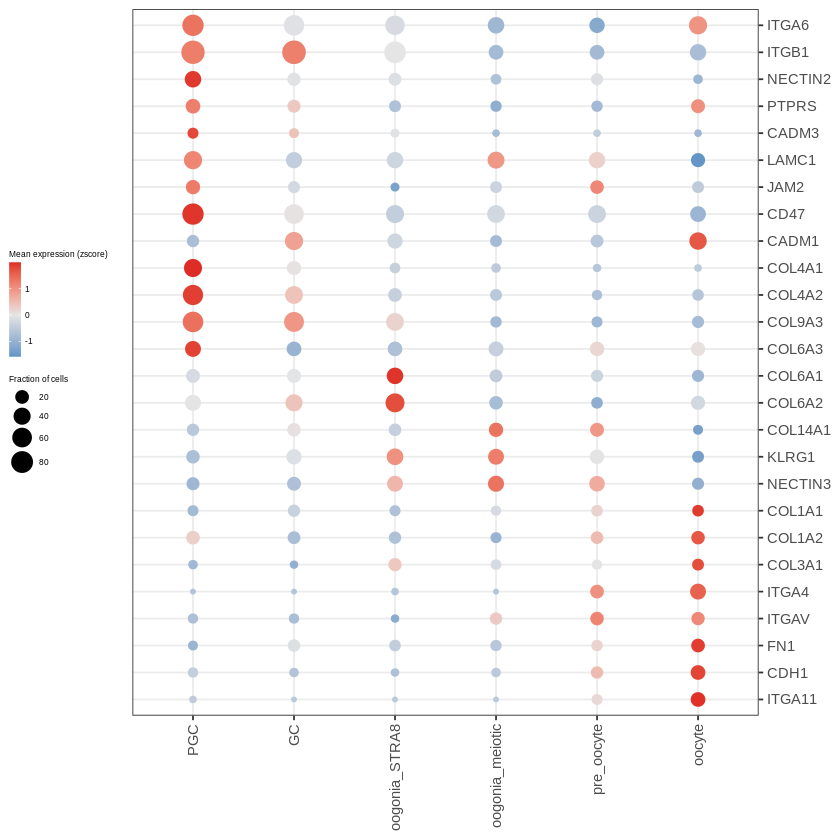

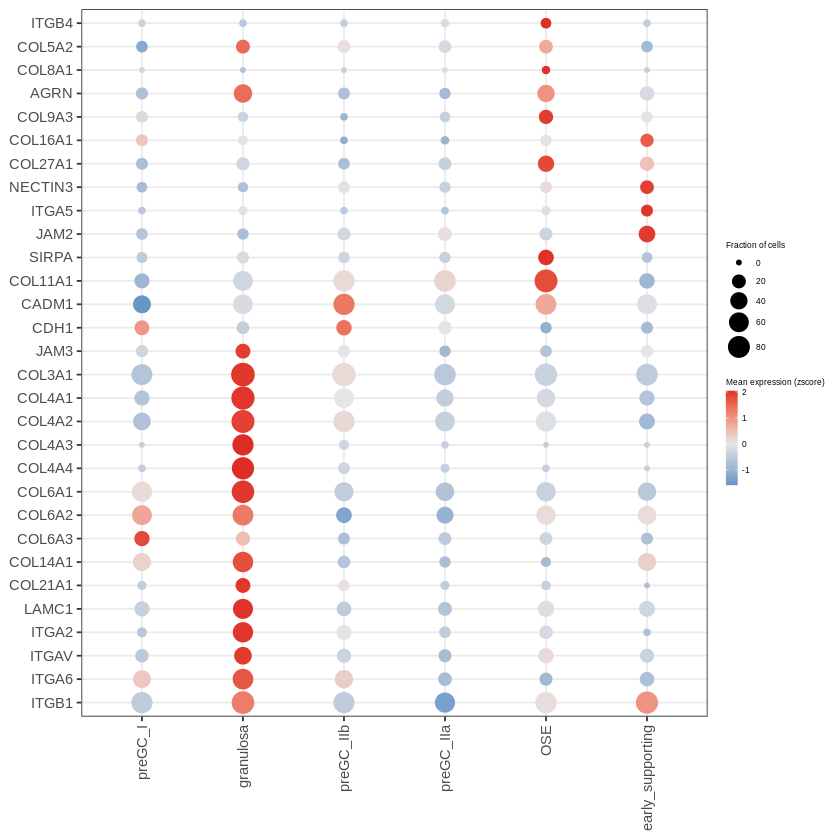

In [11]:
dotplot_genes2lineageV1(germ, rev(EMC_germ), mdf_germ, legend_loc='left')
ggsave(filename = paste0(outdir,'EMC_germ.pdf'), dpi = 300, width = 3.6, height = 5)


dotplot_genes2lineageV1(somatic, rev(EMC_soma), mdf_somatic, legend_loc='right')
ggsave(filename = paste0(outdir,'EMC_somatic.pdf'), dpi = 300, width = 3.6, height = 6)

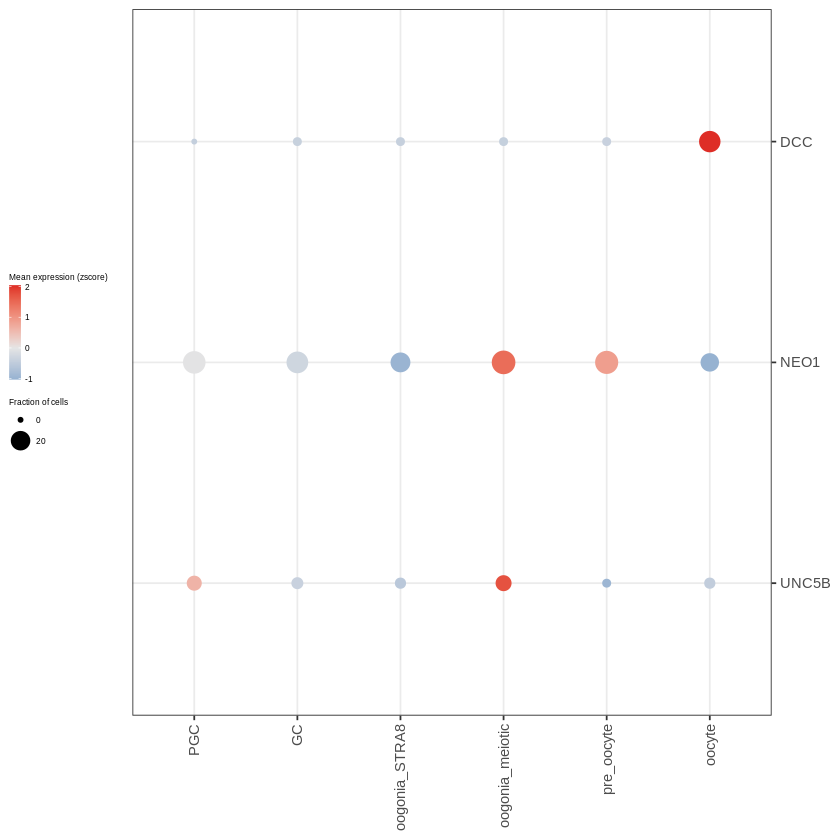

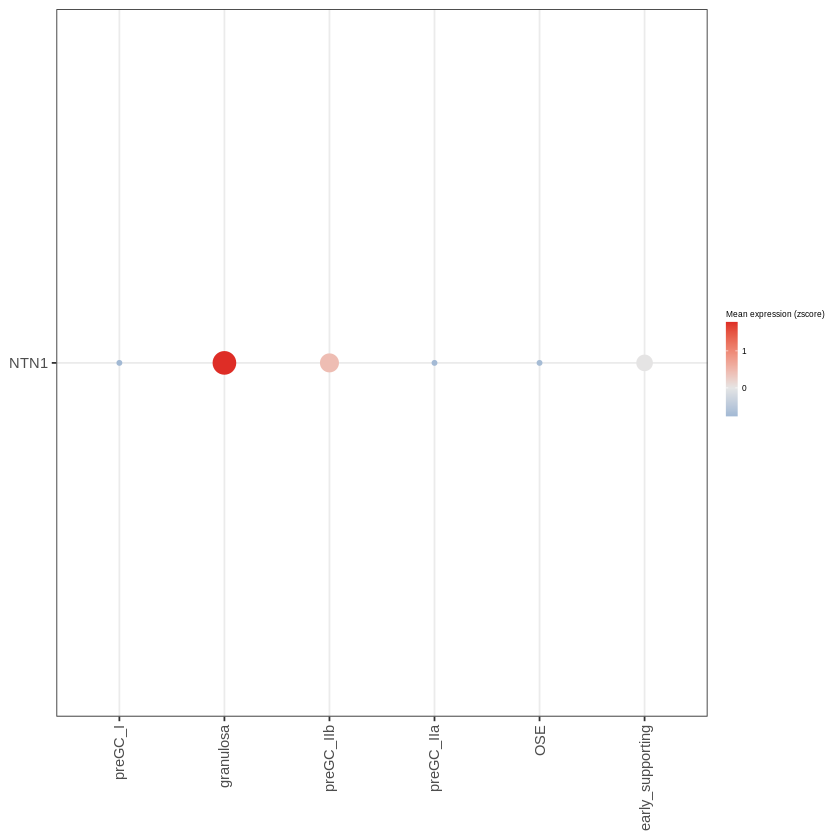

In [12]:
follicle_somatic = c('NTN1')
follicle_germ = c('DCC', 'NEO1', 'UNC5B') 


dotplot_genes2lineageV1(germ, rev(follicle_germ), mdf_germ, legend_loc='left')
ggsave(filename = paste0(outdir,'test.pdf'), dpi = 300, width = 3.6, height = 4)
dotplot_genes2lineageV1(somatic, rev(follicle_somatic), mdf_somatic, legend_loc='right')